In [1]:
!pip install transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.0 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login

login()

In [3]:
import numpy as np
import pandas as pd
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import random

In [4]:
model_name = "meta-llama/Llama-2-13b-chat-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model in 4-bit precision
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype="auto"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

Add data

In [5]:
file_path = r"/content/all_data.csv"
data = pd.read_csv(file_path)

<ipython-input-5-08146613f25a>:2: DtypeWarning: Columns (8,9,31,32,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [6]:
tasks = ['Free recall', 'Lexical decision', 'Cued recall', 'Single recognition', 'Associative recognition']

In [7]:
task_data = {task: data[data['condition'] == task] for task in tasks}

In [8]:
cleaned_tasks = {}

cleaned_tasks['Free recall'] = task_data['Free recall'][['subject', 'trial', 'resp.string','stim.string.left']].dropna()
cleaned_tasks['Lexical decision'] = task_data['Lexical decision'][['subject', 'stim.string.left', 'resp', 'rt']].dropna()
cleaned_tasks['Cued recall'] = task_data['Cued recall'][['subject', 'trial', 'stim.string.left', 'resp.string']].dropna()
cleaned_tasks['Single recognition'] = task_data['Single recognition'][['subject', 'stim.string.left', 'resp']].dropna()
cleaned_tasks['Associative recognition'] = task_data['Associative recognition'][['subject', 'stim.string.left', 'stim.string.right', 'resp']].dropna()

- Single Recognition


In [9]:
associative_recognition_data = cleaned_tasks['Associative recognition']

In [10]:
associative_recognition_data.shape

(26842, 4)

In [11]:
associative_recognition_data.head()

,subject,stim.string.left,stim.string.right,resp
0,2,CLAIM,SCATTERED,1
1,2,SHARPLY,STRESS,1
2,2,FORMER,VOLUME,1
3,2,CONTROLS,REMAINING,1
4,2,TRACK,APPARENTLY,1


I will need study phase as Associative recognition is a memory task that involves determining whether a pair of itmes that were previously studied together are presented as they were originally paired.

- Pair : stim.string.left and stim.string.right

- Study phase - Old items studied
- Test phase - some old items(1) and some new(0)


combining study + test phase

In [12]:
def generate_prompt_for_associative_recognition(study_pairs, test_pair):

    study_phase = "This is a list of PAIR WORDS that you have to remember-\nSTUDY LIST::\n"
    for left, right in study_pairs:
        study_phase += f"- {left} - {right}\n"

    test_phase = ("Now, decide whether the following pair of words was presented in the STUDY LIST:\n"
                  f"Pair: {test_pair[0]} - {test_pair[1]}\n"
                  "Respond with '1' if it was presented as a pair or '0' if it was not.\nModel Output: ")

    return study_phase + "\n" + test_phase

In [13]:
def ask_llm_v2(prompt, tokenizer, model):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    output = model.generate(
        **inputs,
        max_new_tokens=100,
        temperature=0.2,
        top_p=0.95,
        eos_token_id=tokenizer.eos_token_id
    )
    response = tokenizer.decode(output[0], skip_special_tokens=True).strip()
    return response

In [26]:
def get_model_responses_associative_recognition(study_pairs, test_data, tokenizer, model):
    # Study phase
    #study_prompt = generate_study_phase_prompt(study_items)
    #print("--Study Phase Prompt--")
    #print(study_prompt)
    #ask_llm_v2(study_prompt, tokenizer, model)
    model_responses = []
    # Test phase
    for test_pair in test_data:
        prompt = generate_prompt_for_associative_recognition(study_pairs, test_pair)
        print("--Prompt--")
        print(prompt)
        response = ask_llm_v2(prompt, tokenizer, model)
        print("--Response--")
        print(response)

        response_cleaned =int(input("#######Manually add model output: "))
        print("--Cleaned Response--")
        print(response_cleaned)
        model_responses.append(response_cleaned)

    return model_responses

In [15]:
new_associative_recognition_data = associative_recognition_data.sample(15)

In [16]:
new_associative_recognition_data.head()

,subject,stim.string.left,stim.string.right,resp
41144,187,ENORMOUS,PREVIOUS,0
15787,71,TRANSPORTATION,ISLANDS,0
114999,378,SHIRT,FORMING,1
4938,26,DISAPPEARED,REPLACE,1
39287,180,RUNS,MAPS,0


In [18]:
sampled_study_rows = new_associative_recognition_data.sample(10)
study_items = list(zip(sampled_study_rows['stim.string.left'], sampled_study_rows['stim.string.right']))
study_items

[('TRANSPORTATION', 'ISLANDS'),
 ('ACTED', 'RISK'),
 ('SHIRT', 'FORMING'),
 ('INSECTS', 'REMAINING'),
 ('FIRMLY', 'FENCE'),
 ('FAILURE', 'WORKER'),
 ('ROMAN', 'CHAIN'),
 ('ENORMOUS', 'PREVIOUS'),
 ('INDUSTRIES', 'SUIT'),
 ('SIGNIFICANT', 'BENT')]

In [19]:
sampled_test_rows = new_associative_recognition_data.sample(5)
test_items = list(zip(sampled_test_rows['stim.string.left'], sampled_test_rows['stim.string.right']))
test_items

[('ENORMOUS', 'PREVIOUS'),
 ('UPSET', 'CHINESE'),
 ('DISAPPEARED', 'REPLACE'),
 ('INSECTS', 'REMAINING'),
 ('STRETCH', 'CHRISTIAN')]

In [24]:
human_responses =[]

for left, right in test_items:
    print(f"Checking pair: ({left}, {right})")

    for idx, (stim_left, stim_right) in enumerate(zip(new_associative_recognition_data["stim.string.left"],
                                                      new_associative_recognition_data["stim.string.right"])):
        if left == stim_left and right == stim_right:
            human_responses.append(new_associative_recognition_data["resp"].iloc[idx])

print("Human Responses:", human_responses)

Checking pair: (ENORMOUS, PREVIOUS)
Checking pair: (UPSET, CHINESE)
Checking pair: (DISAPPEARED, REPLACE)
Checking pair: (INSECTS, REMAINING)
Checking pair: (STRETCH, CHRISTIAN)
Human Responses: [0, 0, 1, 1, 0]


In [27]:
model_responses = get_model_responses_associative_recognition(study_items, test_items, tokenizer, model)

--Prompt--
This is a list of PAIR WORDS that you have to remember-
STUDY LIST::
- TRANSPORTATION - ISLANDS
- ACTED - RISK
- SHIRT - FORMING
- INSECTS - REMAINING
- FIRMLY - FENCE
- FAILURE - WORKER
- ROMAN - CHAIN
- ENORMOUS - PREVIOUS
- INDUSTRIES - SUIT
- SIGNIFICANT - BENT

Now, decide whether the following pair of words was presented in the STUDY LIST:
Pair: ENORMOUS - PREVIOUS
Respond with '1' if it was presented as a pair or '0' if it was not.
Model Output: 
--Response--
This is a list of PAIR WORDS that you have to remember-
STUDY LIST::
- TRANSPORTATION - ISLANDS
- ACTED - RISK
- SHIRT - FORMING
- INSECTS - REMAINING
- FIRMLY - FENCE
- FAILURE - WORKER
- ROMAN - CHAIN
- ENORMOUS - PREVIOUS
- INDUSTRIES - SUIT
- SIGNIFICANT - BENT

Now, decide whether the following pair of words was presented in the STUDY LIST:
Pair: ENORMOUS - PREVIOUS
Respond with '1' if it was presented as a pair or '0' if it was not.
Model Output: 1
#######Manually add model output: 1
--Cleaned Response--
1


In [28]:
model_responses

[1, 0, 0, 1, 0]

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [30]:
human_responses = [int(hr) for hr in human_responses]
model_responses = [int(mr) for mr in model_responses]

In [31]:
accuracy = accuracy_score(human_responses, model_responses)
precision = precision_score(human_responses, model_responses, zero_division=0)
recall = recall_score(human_responses, model_responses, zero_division=0)
f1 = f1_score(human_responses, model_responses, zero_division=0)

In [32]:
print(f"Accuracy : {accuracy}")
print(f"Precision: {precision}")
print(f"recall : {recall}")
print(f"f1 : {f1}")

Accuracy : 0.6
Precision: 0.5
recall : 0.5
f1 : 0.5


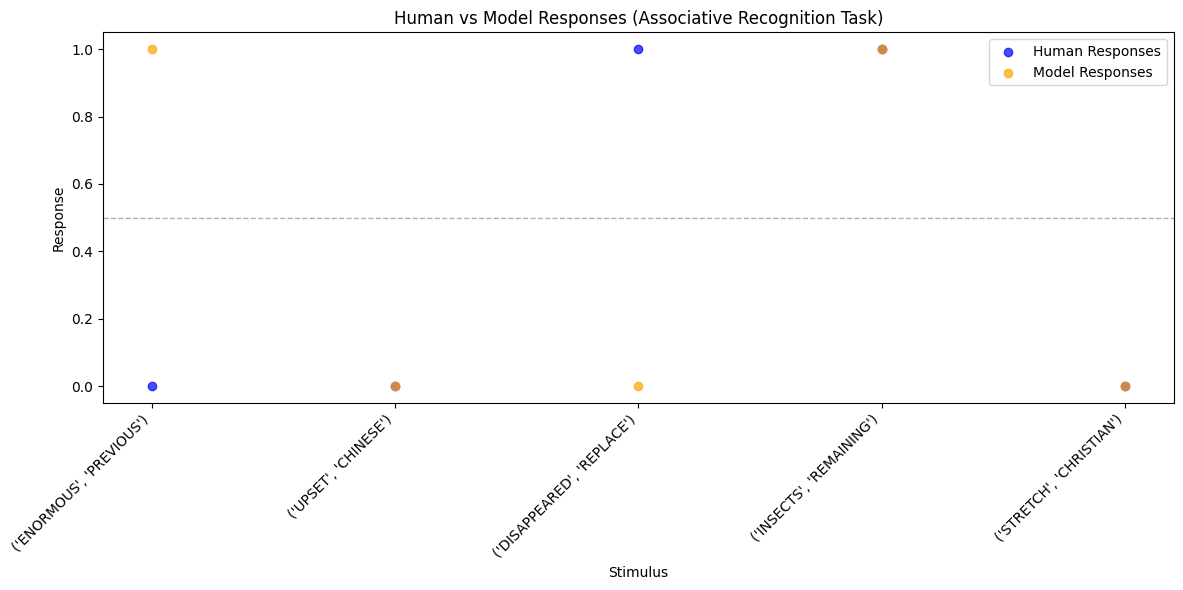

In [34]:
import matplotlib.pyplot as plt

data = {
    "Stimulus": test_items,
    "Human Response": human_responses,
    "Model Response": model_responses,
}


df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))


plt.scatter(df.index, df["Human Response"], label="Human Responses", color='blue', alpha=0.7)
plt.scatter(df.index, df["Model Response"], label="Model Responses", color='orange', alpha=0.7)


plt.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, alpha=0.6)  # Midline
plt.xticks(df.index, df["Stimulus"], rotation=45, ha="right")
plt.xlabel("Stimulus")
plt.ylabel("Response")
plt.title("Human vs Model Responses (Associative Recognition Task)")
plt.legend()
plt.tight_layout()

# Show Plot
plt.show()
